In [ ]:
!pip install selenium
from bokeh.io import curdoc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, output_file, export_png, export_svg
from bokeh.models import ColumnDataSource,LinearColorMapper,BasicTicker,ColorBar
from IPython.display import Image,SVG, display
curdoc().theme = "dark_minimal"
output_notebook()
output_file("chart.html")

In [2]:
df=pd.read_csv("cofe_tea.csv")
df.head()

,Отметка времени,Кофе или чай?,Пол,Занимаетесь спортом?,Есть ли работа?,Есть ли сердечные заболевания?,Сова или Жаворонок,Есть ли молоко в холодильнике?,Время подъема,Административный округ,Время сна
0,19.09.2023 20:21:52,Чай,М,Нет,Да,Нет,Жаворонок,Нет,6-7 утра,NaN,7-8 часов
1,19.09.2023 20:22:58,Кофе,М,Да,Да,Нет,Сова,Да,5-6 утра,Юго-Восточный административный округ,7-8 часов
2,19.09.2023 20:23:16,Чай,М,Да,Нет,Нет,Сова,Нет,Позднее 8 утра,Восточный административный округ,7-8 часов
3,19.09.2023 20:23:27,Чай,М,Нет,Нет,Нет,Сова,Нет,Позднее 8 утра,Южный административный округ,7-8 часов
4,19.09.2023 20:24:34,Чай,Ж,Нет,Да,Нет,Сова,Да,Позднее 8 утра,Южный административный округ,Более 8 часов


In [3]:
result='cofe/tea'
r={'5-6 утра':5.5,'6-7 утра':6.5,'7-8 утра':7.5,'Позднее 8 утра':8.5}
s={'Менее 3 часов':3,'От 3 до 6 часов':5,'7-8 часов':7.5,'Более 8 часов':8.5}
ndf=pd.DataFrame(columns=['timestamp','sex','sport','job','heart diseases','owl/lark','milk','raise','location','sleep','cofe/tea'])
ndf['timestamp']=df['Отметка времени'].apply(lambda x:datetime.strptime(x, "%d.%m.%Y %H:%M:%S").timestamp())
ndf['sex']=df['Пол'].apply(lambda x: x=='М')
ndf['sport']=df['Занимаетесь спортом?'].apply(lambda x: x=='Да')
ndf['job']=df['Есть ли работа?'].apply(lambda x: x=='Да')
ndf['heart diseases']=df['Есть ли сердечные заболевания?'].apply(lambda x: x=='Да')
ndf['owl/lark']=df['Сова или Жаворонок'].apply(lambda x: x=='Сова')
ndf['milk']=df['Есть ли молоко в холодильнике?'].apply(lambda x: x=='Да')
ndf['raise']=df['Время подъема'].apply(lambda x: r[x])
ndf['location']=df['Административный округ'].apply(lambda x: hash(x))
ndf['sleep']=df['Время сна'].apply(lambda x: s[x])
ndf['cofe/tea']=df['Кофе или чай?'].apply(lambda x: x=='Кофе')
ndf.head()

,timestamp,sex,sport,job,heart diseases,owl/lark,milk,raise,location,sleep,cofe/tea
0,1.695144e+09,True,False,True,False,False,False,6.5,131159059637,7.5,False
1,1.695144e+09,True,True,True,False,True,True,5.5,5108242535803805024,7.5,True
2,1.695144e+09,True,True,False,False,True,False,8.5,6238222152442752709,7.5,False
3,1.695144e+09,True,False,False,False,True,False,8.5,-4007479705659915048,7.5,False
4,1.695144e+09,False,False,True,False,True,True,8.5,-4007479705659915048,8.5,False


In [4]:
x=ndf.loc[:,ndf.columns!=result]
y=ndf.loc[:,ndf.columns==result].values.ravel()

In [5]:
def classif(x,y,k,test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)
    knn = KNeighborsClassifier(n_neighbors=k).fit(x_train,y_train)
    y_predict=knn.predict(x_test)
    n=min(len(y_test),len(y_predict))
    return sum([1 if y_test[i]==y_predict[i] else 0 for i in range(n)])/n

In [138]:
def plot(xyz, filename):
    xyz=pd.DataFrame(xyz)
    TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"
    p = figure(
        title="The correctness of the definition depends on the size of the sample being tested and the number of neighbors",
        width=1000,
        height=1000,
        tools=TOOLS,tooltips=[("k","@x"),("test_size","@y"),("correct","@percent")],
        x_axis_label="neighbors",
        y_axis_label="test size"
    )
    xyz['color']=xyz['z'].map(lambda z:(z*255, 0, (1-z)*255))
    xyz['percent']=xyz['z'].map(lambda z:f'{z*100:.2f}%')
    p.circle(x='x', y='y', source=ColumnDataSource(xyz), radius=0.05,color='color', fill_alpha=1)
    color_bar=ColorBar(
        color_mapper=LinearColorMapper(palette=[f'#{int(i):02x}00{255-int(i):02x}' for i in np.linspace(0,255,255)],low=0,high=1),
        ticker=BasicTicker(desired_num_ticks = 10),
        location=(0,0)
    )

    p.add_layout(color_bar,'right')
    # github don't display js and css
    if(filename.endswith(".html")):
        show(p)
    elif (filename.endswith(".png")):
        export_png(p, filename=filename)
        display(Image(filename=filename))
    elif (filename.endswith(".svg")): 
        export_svg(p, filename=filename)
        display(SVG(filename=filename))
    else: 
        print("not supported type")

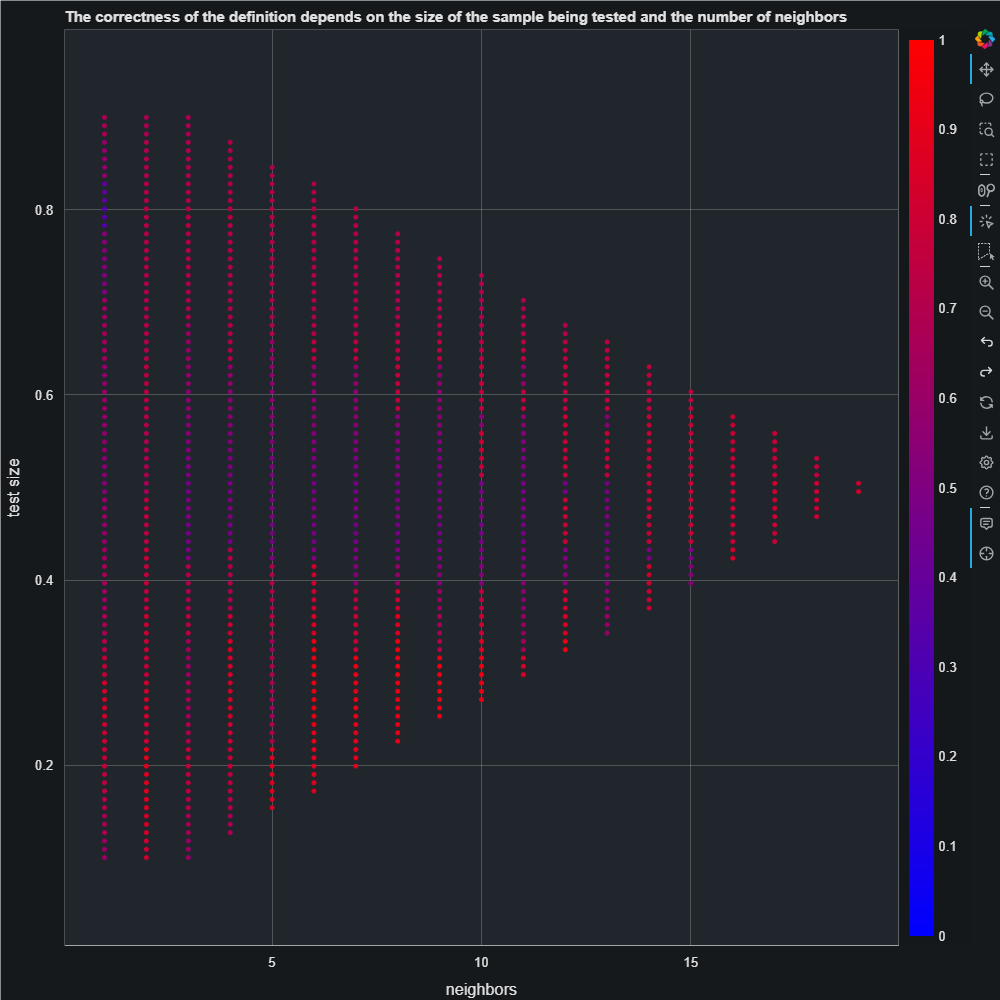

In [143]:
xyz={'x':[],'y':[],'z':[]}
for i in np.linspace(0.1, 0.9, num=90):
    for j in range(1,int(len(y)*min(i,1-i))):
        xyz['x'].append(j)
        xyz['y'].append(i)
        xyz['z'].append(classif(x,y,j,i))
plot(xyz,"chart.png")